In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import random
import sys
import gc
import pickle
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelBinarizer
import PIL
from PIL import Image
from IPython.display import SVG
from keras.utils import model_to_dot
import platform

import keras
from keras import layers
from keras import metrics
from keras.models import load_model
from keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D, GlobalAveragePooling2D, Dropout
from keras import optimizers
from keras import models
from keras.models import Sequential
from keras import preprocessing
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.applications import VGG16
from keras.utils import plot_model

2023-09-27 15:42:58.380820: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-27 15:42:58.415649: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-27 15:42:58.986099: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Enable CUDA if OS is Windows

In [2]:
if platform.system() == 'Windows': 
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Set path and get all classes. ".DS_Store" needs to be removed on MacOS again

In [3]:
d = '/home/sebastian/Documents/Hauptprojekt/Daten_sorted/'
classes = (os.listdir(d))
if ".DS_Store" in classes:
    classes.remove(".DS_Store")
if "._.DS_Store" in classes:
    classes.remove("._.DS_Store")

In [4]:
print(classes)

['sales_order', 'purchase_order', 'utility_bill', 'debit_note', 'order', 'receipt', 'proforma', 'tax_invoice', 'credit_note']


Global variables

In [5]:
img_size = 224
batch_size = 32
epochs = 100
mod_tax = 10
mod_order = 5
train_size = 0.7
val_size = 0.2
test_size = 0.1
seed = 4321
channels = 3
learning_rate = 0.00001

Get all Data. Because the Dataset is unbalanced we use only every 10th image of "tax_invoice" and every 5th image of "order"

In [6]:
total_set = []
total_labels = []
counter_tax = 0 
counter_order = 0

for root, dirs, files in os.walk(d):
    for file in files:
        if file.endswith(".jpg"):
            label = root.split(os.path.sep)[-1]
            if label == "tax_invoice":
                counter_tax +=1
                if counter_tax % mod_tax == 0:
                    path = os.path.join(root, file)
                    total_set.append(path)
                    total_labels.append(label)
            elif label == "order":
                counter_order +=1
                if counter_order % mod_order == 0:
                    path = os.path.join(root, file)
                    total_set.append(path)
                    total_labels.append(label)
            else:    
                path = os.path.join(root, file)
                total_set.append(path)
                total_labels.append(label)
            

# Return image class based on list entry (path)         
def getClass(img):
    return img.split(os.path.sep)[-2]


print(total_set[0])
print('GetClass : ', getClass(total_set[0]))
print('Label : ', total_labels[0])

/home/sebastian/Documents/Hauptprojekt/Daten_sorted/sales_order/synthetic-6a8be7d3aa8c44d6af9a2656-052(1).jpg
GetClass :  sales_order
Label :  sales_order


In [19]:
len(total_set)

19395

In [20]:
img = mpimg.imread("/home/sebastian/Documents/Hauptprojekt/Daten_sorted/debit_note/2aeea3060ec34935b5a2a6e9(2).jpg")

Plot random samples

/home/sebastian/Documents/Hauptprojekt/Daten_sorted/tax_invoice/synthetic-60342157e5654d1292205df4-813(1).jpg


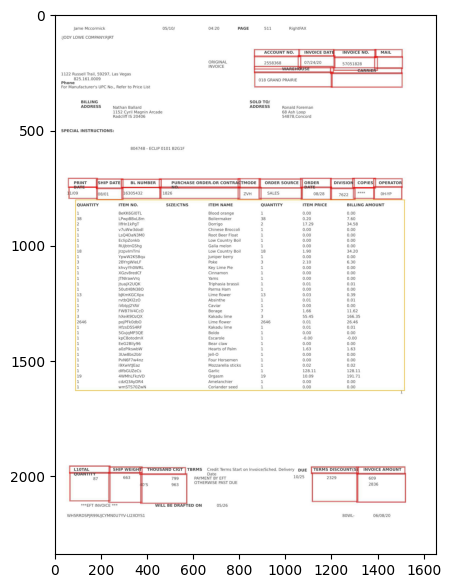

/home/sebastian/Documents/Hauptprojekt/Daten_sorted/receipt/synthetic-410651d35003486c860e6985-120(1).jpg


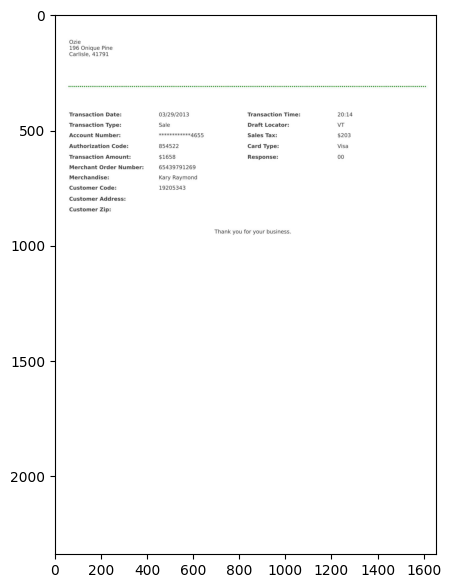

/home/sebastian/Documents/Hauptprojekt/Daten_sorted/tax_invoice/synthetic-1c5cf2840ec745479b53bcad-958(1).jpg


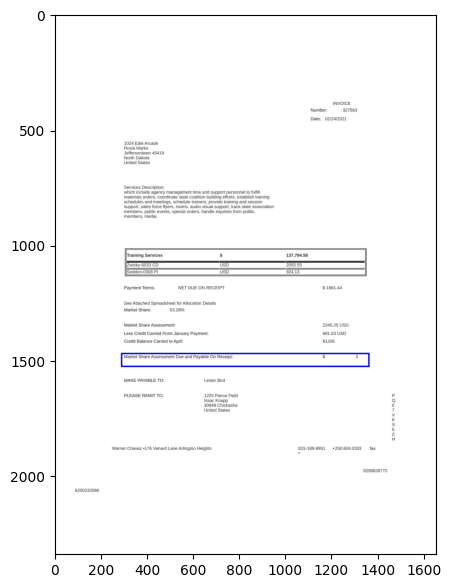

In [21]:
random.Random(seed).shuffle(total_set)

for ima in total_set[0:3] :
    print(ima)
    img = mpimg.imread(ima)
    plt.figure(figsize=(7,7))
    imgplot = plt.imshow(img, cmap="gray")
    plt.show()

Sorting the data in test, train and validation sets


In [33]:
# Get data and separate it in sets
total_len = len(total_set)
index = 0

train_set = []
train_label = []

val_set = []
val_label = []

test_set = []
test_label = []


for i in total_set[0: int(total_len*train_size)] :
    train_set.append(i)
    train_label.append(getClass(i))

    
index = int(total_len*train_size)+1
    
for i in total_set[index: int(index + total_len*val_size)] :
    val_set.append(i)
    val_label.append(getClass(i))
    
index = int(index + total_len*val_size)+1 

for i in total_set[index: total_len] :
    test_set.append(i)
    test_label.append(getClass(i))

print(train_set[750])
print(train_label[750])

/home/sebastian/Documents/Hauptprojekt/Daten_sorted/sales_order/synthetic-6a8be7d3aa8c44d6af9a2656-598(1).jpg
sales_order


Visualizing class distribution for each set

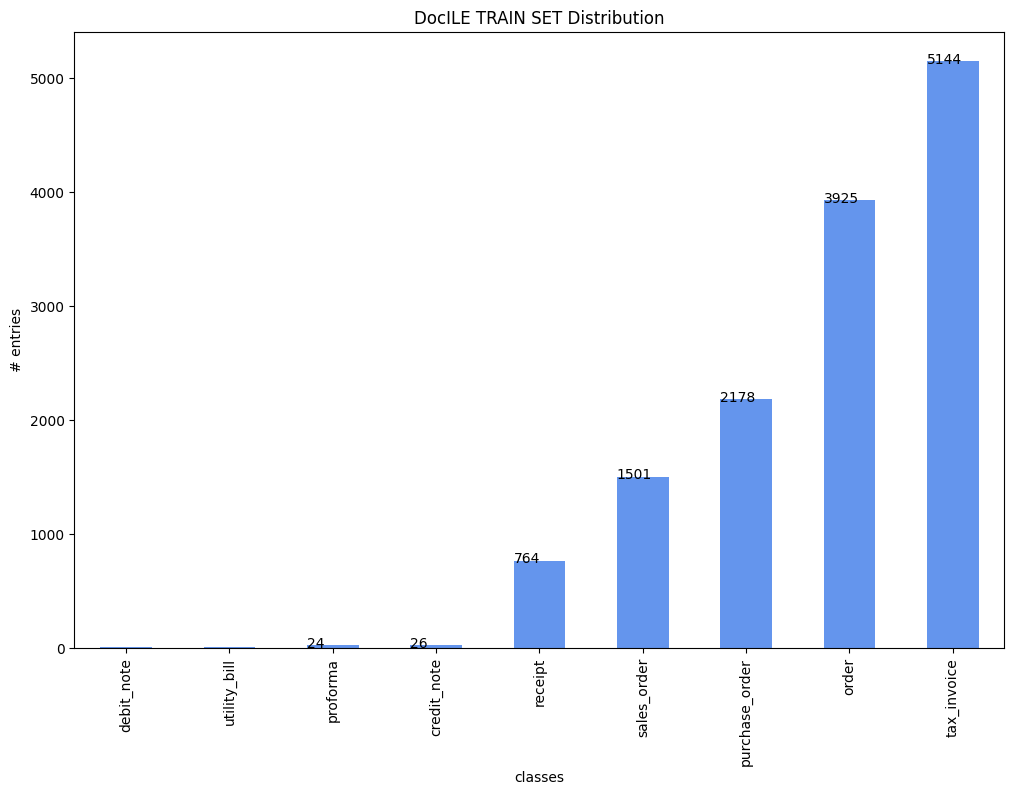

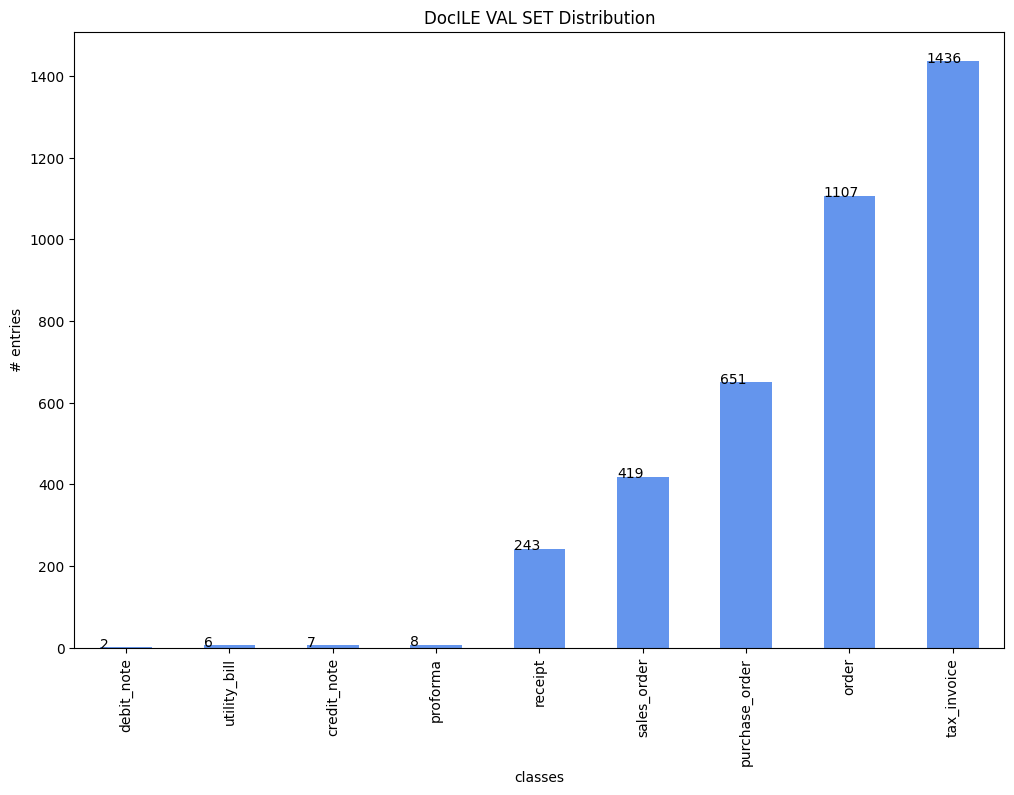

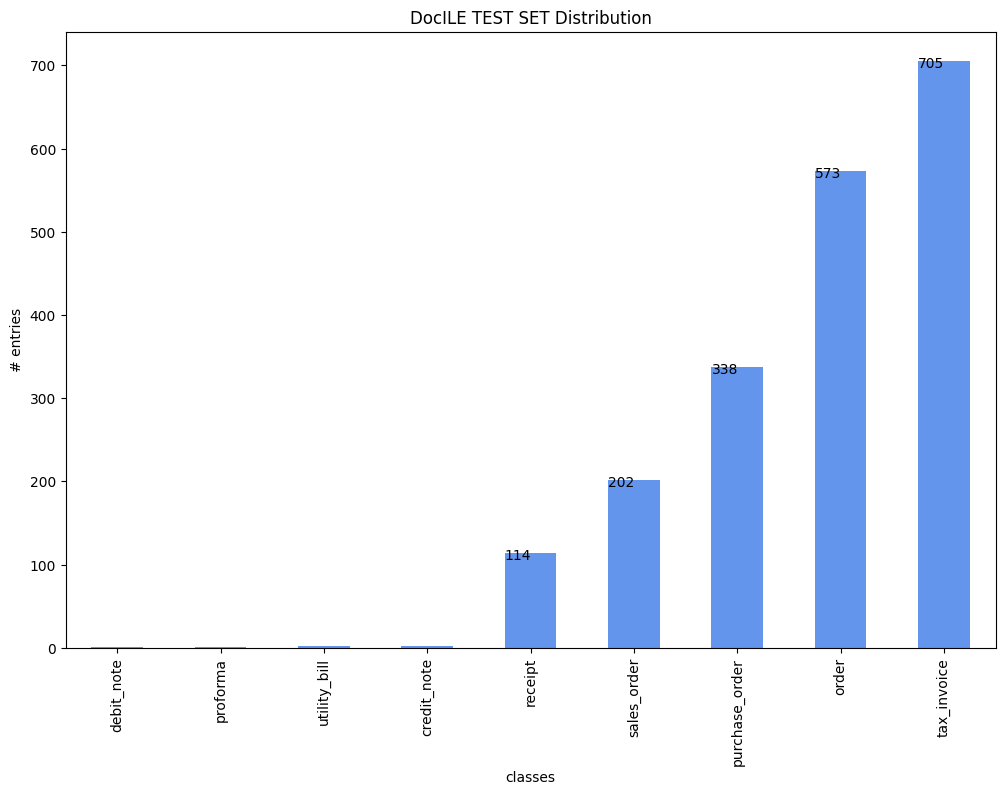

In [23]:
#################################################
# TRAIN SET
instances = [0] * len(classes)
for index, val in enumerate(classes) :
    for e in train_set :
        if(val == getClass(e)) :
            instances[index] += 1

            
df = pd.DataFrame({'classes':classes, 'entries':instances})
ax = df.sort_values(by='entries', ascending=True).plot.bar(x='classes', y='entries', color='cornflowerblue',legend=False, figsize=(12,8))
ax.set_title('DocILE TRAIN SET Distribution')
ax.set_ylabel("# entries")
for p in ax.patches:
    ax.annotate(str(p.get_height()), xy=(p.get_x(), p.get_height()-20))

#################################################
# VAL SET
instances = [0] * len(classes)
for index, val in enumerate(classes) :
    for e in val_set :
        if(val == getClass(e)) :
            instances[index] += 1

            
df = pd.DataFrame({'classes':classes, 'entries':instances})
ax = df.sort_values(by='entries', ascending=True).plot.bar(x='classes', y='entries', color='cornflowerblue',legend=False, figsize=(12,8))
ax.set_title('DocILE VAL SET Distribution')
ax.set_ylabel("# entries")
for p in ax.patches:
    ax.annotate(str(p.get_height()), xy=(p.get_x(), p.get_height()-3))
    
#################################################
# TEST SET
instances = [0] * len(classes)
for index, val in enumerate(classes) :
    for e in test_set :
        if(val == getClass(e)) :
            instances[index] += 1

            
df = pd.DataFrame({'classes':classes, 'entries':instances})
ax = df.sort_values(by='entries', ascending=True).plot.bar(x='classes', y='entries', color='cornflowerblue',legend=False, figsize=(12,8))
ax.set_title('DocILE TEST SET Distribution')
ax.set_ylabel("# entries")
for p in ax.patches:
    ax.annotate(str(p.get_height()), xy=(p.get_x(), p.get_height()-8))

Preprocess data (resize, transform to Numpy array and binarize)

In [114]:
def process_images(img_set) : 
    processed_img = []
    counter = 0

    for i in range(len(img_set)):
        processed_img.append(cv2.resize(cv2.imread(img_set[i], cv2.IMREAD_COLOR), (img_size, img_size)))
 
    return processed_img
    
data_train = process_images(train_set)

In [115]:
def process_images(img_set) : 
    processed_img = []

    for i in range(len(img_set)):
            processed_img.append(cv2.resize(cv2.imread(img_set[i], cv2.IMREAD_COLOR), (img_size, img_size)))    
    
    return processed_img
    
data_test = process_images(test_set)

In [116]:
def process_images(img_set) : 
    processed_img = []

    for i in range(len(img_set)):
              processed_img.append(cv2.resize(cv2.imread(img_set[i], cv2.IMREAD_COLOR), (img_size, img_size)))
        
    return processed_img

In [117]:
test_set[200]

'/home/sebastian/Documents/Hauptprojekt/Daten_sorted/sales_order/synthetic-6a8be7d3aa8c44d6af9a2656-162(1).jpg'

use the LabelBinarizer. Documentation and functionality can be found here: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html

In [12]:
lb = LabelBinarizer()
lb.fit(list(classes))

x_train = np.array(data_train)
y_train =lb.transform(np.array(train_label))

x_test = np.array(data_test)
y_test = lb.transform(np.array(test_label))

x_val = np.array(data_val)
y_val = lb.transform(np.array(val_label))

print("train images shape : ", x_train.shape)
print("train labels shape : ", y_train.shape)
print(x_train[0])

print("test shape : ", x_test.shape)
print(y_test.shape)
print("valdiation shape : ", x_val.shape)
print(y_val.shape)


for i in range(3) :
    plt.figure(figsize=(6,6))
    imgplot = plt.imshow(x_train[i])


print(train_label[0])
print(y_train[0])
print(lb.classes_)

NameError: name 'data_train' is not defined

Save the sets to .npy file for use after restarting runtime

In [123]:
np.save('/home/sebastian/Documents/Hauptprojekt/Arrays/VGG16/x_train.npy', x_train)
np.save('/home/sebastian/Documents/Hauptprojekt/Arrays/VGG16/x_test.npy', x_test)
np.save('/home/sebastian/Documents/Hauptprojekt/Arrays/VGG16/y_train.npy', y_train)
np.save('/home/sebastian/Documents/Hauptprojekt/Arrays/VGG16/y_test.npy', y_test)
np.save('/home/sebastian/Documents/Hauptprojekt/Arrays/VGG16/x_val.npy', x_val)
np.save('//home/sebastian/Documents/Hauptprojekt/Arrays/VGG16/y_val.npy', y_val)

load sets after restarting runtime

In [6]:
x_train = np.load('/home/sebastian/Documents/Hauptprojekt/Arrays/VGG16/x_train.npy')
x_test = np.load('/home/sebastian/Documents/Hauptprojekt/Arrays/VGG16/x_test.npy')
y_train = np.load('/home/sebastian/Documents/Hauptprojekt/Arrays/VGG16/y_train.npy')
y_test = np.load('/home/sebastian/Documents/Hauptprojekt/Arrays/VGG16/y_test.npy')
x_val = np.load('/home/sebastian/Documents/Hauptprojekt/Arrays/VGG16/x_val.npy')
y_val = np.load('/home/sebastian/Documents/Hauptprojekt/Arrays/VGG16/y_val.npy')

### Load Model

With "layer.trainable = False" you can freeze the layers of the base model. That means when your training the model that you only train the layers added to the base model. Training the whole model takes about three to four times longer for training since there are way more parameters to train.

For this project two models were testet. One with "layer.trainable = False" and one without it. 

In [67]:
base_model = VGG16(weights = "imagenet", include_top=False, input_shape = (img_size, img_size, channels))

for layer in base_model.layers:
    layer.trainable = False
    
if layer.trainable == False:
    name_layer = "_added_layer_"
elif layer.trainable == True:
    name_layer = "_all_layer_"
    
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### Create custom model

Base is VGG16, adding a flatten layer, a Dense layer and a dropout layer. Last Dense layer specify the number of classes

In [8]:
model = models.Sequential()

model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu',  name='dense'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(classes), activation='softmax',  name='predictions'))

model.summary()

print('Number of trainable weights : ', len(model.trainable_weights))

plot_model(model, to_file='model_VGG-16.png')
#SVG(model_to_dot(model).create(prog='dot', format='svg'))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 predictions (Dense)         (None, 9)                 1161      
                                                                 
Total params: 17927241 (68.39 MB)
Trainable params: 17927241 (68.39 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Number of trai

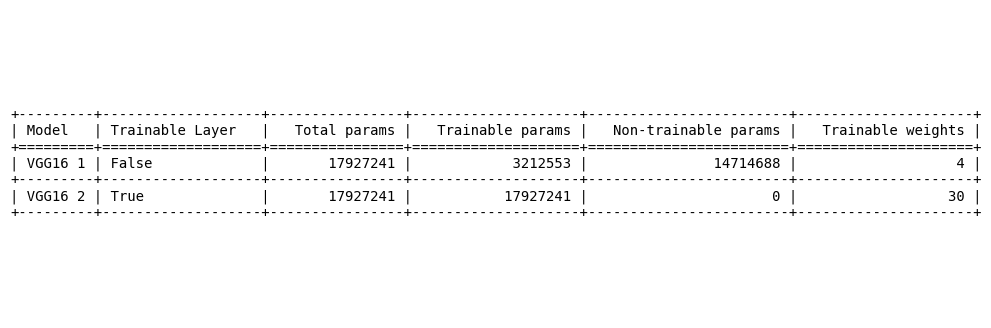

In [9]:
from tabulate import tabulate
from PIL import Image, ImageDraw, ImageFont

# Model information
model1_info = {
    "Model": "VGG16 1",
    "trainable layers": "False",
    "Total params": 17927241,
    "Trainable params": 3212553,
    "Non-trainable params": 14714688,
    "Number of trainable weights": 4
}

model2_info = {
    "Model": "VGG16 2",
    "trainable layers": "True",
    "Total params": 17927241,
    "Trainable params": 17927241,
    "Non-trainable params": 0,
    "Number of trainable weights": 30
}

# Organize model information
models_data = [
    [model1_info["Model"], model1_info["trainable layers"], model1_info["Total params"], model1_info["Trainable params"], model1_info["Non-trainable params"], model1_info["Number of trainable weights"]],
    [model2_info["Model"], model2_info["trainable layers"], model2_info["Total params"], model2_info["Trainable params"], model2_info["Non-trainable params"], model2_info["Number of trainable weights"]]
]

# Table headers
headers = ["Model", "Trainable Layer", "Total params", "Trainable params", "Non-trainable params", "Trainable weights"]

# Create and print the table
table = tabulate(models_data, headers, tablefmt="grid")


# Create a figure and axis with matplotlib
fig, ax = plt.subplots(figsize=(8, 4))

# Remove the axes
ax.axis("off")

# Display the table text on the axis
ax.text(0.5, 0.5, table, va="center", ha="center", fontsize=10, fontfamily="monospace")

# Save the figure as an image
plt.savefig("/home/sebastian/Documents/Hauptprojekt/Models/VGG16/VGG16_table.png", bbox_inches="tight", dpi=300)


### Training the model with DocILE Data. Only the last added layers are trained

Compile : Configures the model for training.

Fit : Trains the model for a given number of epochs

https://keras.io/models/model/

In [10]:
model.compile(optimizer=optimizers.legacy.Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

train_model = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_val, y_val))

Epoch 1/100


2023-09-17 21:56:24.047863: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-09-17 21:56:24.120931: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2023-09-17 21:56:24.122470: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:231] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2023-09-17 21:56:24.122505: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Used ptxas at ptxas
2023-09-17 21:56:24.122622: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-09-17 

425/425 [==============================] - 56s 119ms/step - loss: 0.9808 - accuracy: 0.7695 - val_loss: 0.1215 - val_accuracy: 0.9711
Epoch 2/100
425/425 [==============================] - 49s 114ms/step - loss: 0.1488 - accuracy: 0.9618 - val_loss: 0.0732 - val_accuracy: 0.9850
Epoch 3/100
425/425 [==============================] - 49s 115ms/step - loss: 0.0838 - accuracy: 0.9803 - val_loss: 0.0662 - val_accuracy: 0.9835
Epoch 4/100
425/425 [==============================] - 49s 115ms/step - loss: 0.0602 - accuracy: 0.9839 - val_loss: 0.0629 - val_accuracy: 0.9869
Epoch 5/100
425/425 [==============================] - 49s 115ms/step - loss: 0.0531 - accuracy: 0.9869 - val_loss: 0.0593 - val_accuracy: 0.9871
Epoch 6/100
425/425 [==============================] - 49s 115ms/step - loss: 0.0360 - accuracy: 0.9894 - val_loss: 0.0597 - val_accuracy: 0.9871
Epoch 7/100
425/425 [==============================] - 49s 115ms/step - loss: 0.0306 - accuracy: 0.9915 - val_loss: 0.0623 - val_accurac

Plot accuracy and loss of trained model

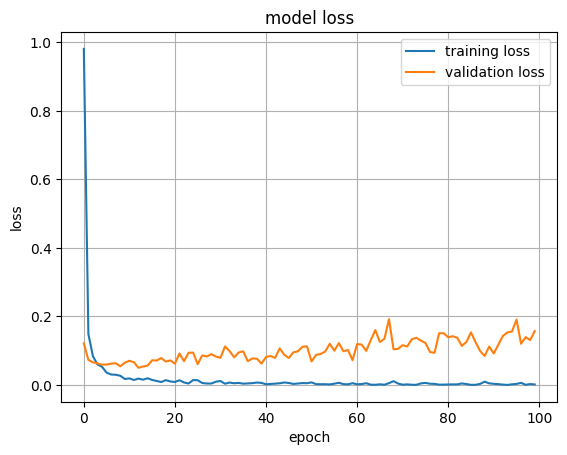

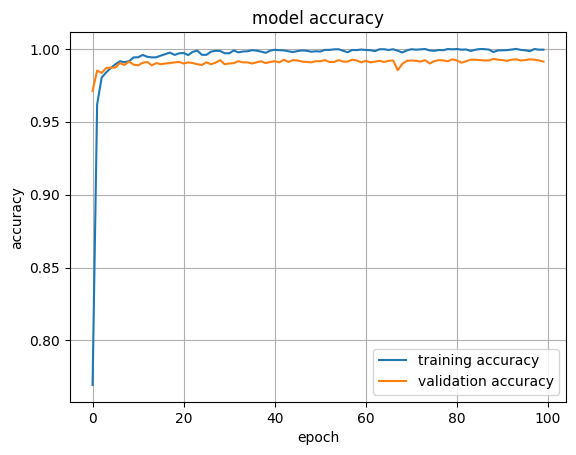

In [11]:
plt.plot(train_model.history['loss'])
plt.plot(train_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.legend(['training loss', 'validation loss'], loc='upper right')
plt.savefig('/home/sebastian/Documents/Hauptprojekt/Plots/ImageClassification/VGG16/model_loss' + str(name_layer) + str(epochs) + 'epochs_' + str(mod_tax) + '_' + str(mod_order) + '.png')
plt.show()

plt.plot(train_model.history['accuracy'])
plt.plot(train_model.history['val_accuracy'])
plt.title('model accuracy')
plt.grid()
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training accuracy', 'validation accuracy'], loc='lower right')
plt.savefig('/home/sebastian/Documents/Hauptprojekt/Plots/ImageClassification/VGG16/model_acc' + str(name_layer) + str(epochs) + 'epochs_' + str(mod_tax) + '_' + str(mod_order) + '.png')
plt.show()

Test prediction accuracy on test set

In [12]:
# combine predictions + average for better score ? 

score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

61/61 [==============================] - 3s 43ms/step - loss: 0.0936 - accuracy: 0.9917
Test loss: 0.09358015656471252
Test accuracy: 0.9917440414428711


In [13]:
with open("/home/sebastian/Documents/Hauptprojekt/Arrays/VGG16/VGG_acc_dict.pkl", "rb") as file:
    VGG_acc_dict = pickle.load(file)
with open("/home/sebastian/Documents/Hauptprojekt/Arrays/VGG16/VGG_loss_dict.pkl", "rb") as file:
    VGG_loss_dict = pickle.load(file)

In [14]:
VGG_acc_dict['VGG16_acc' + str(name_layer) + str(epochs) + 'epochs_' + str(mod_tax) + '_' + str(mod_order)] = score[1]
VGG_loss_dict['VGG16_loss' + str(name_layer) + str(epochs) + 'epochs_' + str(mod_tax) + '_' + str(mod_order)] = score[0]

In [15]:
with open("/home/sebastian/Documents/Hauptprojekt/Arrays/VGG16/VGG_acc_dict.pkl", 'wb') as file:
    pickle.dump(VGG_acc_dict, file)

with open("/home/sebastian/Documents/Hauptprojekt/Arrays/VGG16/VGG_loss_dict.pkl", 'wb') as file:
    pickle.dump(VGG_loss_dict, file)

Save Model with trained last layers

In [16]:
model.save('/home/sebastian/Documents/Hauptprojekt/Models/VGG16/trained_model' + str(name_layer) + str(epochs) + 'epochs_' + str(mod_tax) + '_' + str(mod_order) + '.h5')

/home/sebastian/anaconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [8]:
lb = LabelBinarizer()
lb.fit(list(classes))

LabelBinarizer()

In [9]:
y_test = np.argmax(y_test,axis=1)
y_test_names = lb.classes_[y_test]

In [108]:
epochs = 30
name_layer = "_added_layer_"
#name_layer = "_all_layer_"

In [109]:
from keras.models import load_model
model = load_model('/home/sebastian/Documents/Hauptprojekt/Models/VGG16/trained_model' + str(name_layer) + str(epochs) + 'epochs_10_5.h5')

Use Model on test set

In [110]:
false_pred = []
true_pred = []

predictions=model.predict(x_test) 
predictions_list = predictions.tolist()
predicted_classes=np.argmax(predictions,axis=1)


count_true = 0
count_false = 0

for i, prediction in enumerate(predictions_list):
    state = True
    if (lb.classes_[predicted_classes[i]] != lb.classes_[y_test[i]]) :
        state = False
        count_false += 1
        false_pred.append(lb.classes_[y_test[i]])
    else :
        true_pred.append(lb.classes_[y_test[i]])
        count_true += 1
    
    print("Prediction : ", lb.classes_[predicted_classes[i]], "   |   Real class : ", lb.classes_[y_test[i]],  "   |   Result : ", state)

print("\nNumber of success : ", count_true) 
print("Number of error : ", count_false) 
print("Error rate : ", count_true/len(y_test))

61/61 [==============================] - 2s 35ms/step
Prediction :  tax_invoice    |   Real class :  tax_invoice    |   Result :  True
Prediction :  order    |   Real class :  order    |   Result :  True
Prediction :  order    |   Real class :  order    |   Result :  True
Prediction :  tax_invoice    |   Real class :  tax_invoice    |   Result :  True
Prediction :  order    |   Real class :  order    |   Result :  True
Prediction :  receipt    |   Real class :  receipt    |   Result :  True
Prediction :  order    |   Real class :  order    |   Result :  True
Prediction :  order    |   Real class :  order    |   Result :  True
Prediction :  order    |   Real class :  order    |   Result :  True
Prediction :  tax_invoice    |   Real class :  tax_invoice    |   Result :  True
Prediction :  tax_invoice    |   Real class :  tax_invoice    |   Result :  True
Prediction :  tax_invoice    |   Real class :  tax_invoice    |   Result :  True
Prediction :  purchase_order    |   Real class :  purc

In [111]:
predicted_classes_names = lb.classes_[predicted_classes]
#np.save('/home/sebastian/Documents/Hauptprojekt/Arrays/VGG16/predictions' + str(name_layer) + str(epochs) + 'epochs_' + str(mod_tax) + '_' + str(mod_order) + '.npy', predicted_classes_names)

In [91]:
predicted_classes_names = np.load('/home/sebastian/Documents/Hauptprojekt/Arrays/VGG16/predictions' + str(name_layer) + str(epochs) + 'epochs_' + str(mod_tax) + '_' + str(mod_order) + '.npy')

Print wrong classifications per class

In [112]:
print(f'"debit_note" was classified wrong {false_pred.count("debit_note")} time(s) out of {false_pred.count("debit_note") + true_pred.count("debit_note")} time(s)')
print(f'"proforma" was classified wrong {false_pred.count("proforma")} time(s) out of {false_pred.count("proforma") + true_pred.count("proforma")} time(s)')
print(f'"utility_bill" was classified wrong {false_pred.count("utility_bill")} time(s) out of {false_pred.count("utility_bill") + true_pred.count("utility_bill")} time(s)')
print(f'"credit_note" was classified wrong {false_pred.count("credit_note")} time(s) out of {false_pred.count("credit_note") + true_pred.count("credit_note")} time(s)')
print(f'"receipt" was classified wrong {false_pred.count("receipt")} time(s) out of {false_pred.count("receipt") + true_pred.count("receipt")} time(s)')
print(f'"sales_order" was classified wrong {false_pred.count("sales_order")} time(s) out of {false_pred.count("sales_order") + true_pred.count("sales_order")} time(s)')
print(f'"purchase_order" was classified wrong {false_pred.count("purchase_order")} time(s) out of {false_pred.count("purchase_order") + true_pred.count("purchase_order")} time(s)')
print(f'"order" was classified wrong {false_pred.count("order")} time(s) out of {false_pred.count("order") + true_pred.count("order")} time(s)')
print(f'"tax_invoice" was classified wrong {false_pred.count("tax_invoice")} time(s) out of {false_pred.count("tax_invoice") + true_pred.count("tax_invoice")} time(s)')

"debit_note" was classified wrong 1 time(s) out of 1 time(s)
"proforma" was classified wrong 1 time(s) out of 1 time(s)
"utility_bill" was classified wrong 1 time(s) out of 2 time(s)
"credit_note" was classified wrong 1 time(s) out of 2 time(s)
"receipt" was classified wrong 5 time(s) out of 114 time(s)
"sales_order" was classified wrong 1 time(s) out of 202 time(s)
"purchase_order" was classified wrong 2 time(s) out of 338 time(s)
"order" was classified wrong 2 time(s) out of 573 time(s)
"tax_invoice" was classified wrong 4 time(s) out of 705 time(s)


create result plots

50.0
100.0
0.34904013961605584
100.0
0.591715976331361
4.385964912280701
0.49504950495049505
0.5673758865248227
50.0


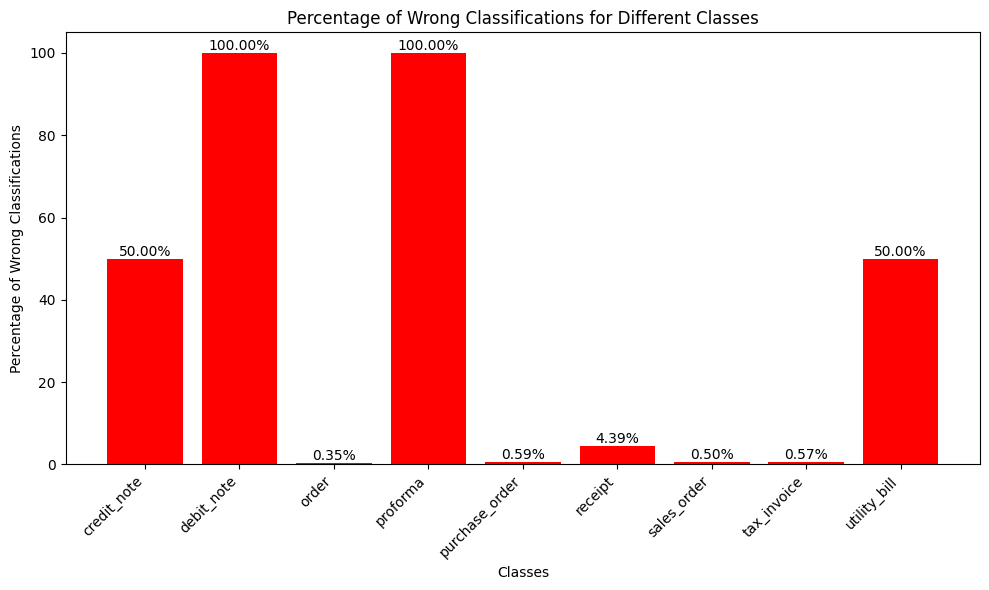

In [113]:
import matplotlib.pyplot as plt
wrong_percentages = [None] * 9
# Data
categories = [
    "credit_note",
    "debit_note",
    "order",
    "proforma",
    "purchase_order",
    "receipt",
    "sales_order",
    "tax_invoice",
    "utility_bill"
]

wrong_counts = [
    false_pred.count("credit_note"),  # credit_note
    false_pred.count("debit_note"),  # debit_note
    false_pred.count("order"), # order
    false_pred.count("proforma"),  # proforma
    false_pred.count("purchase_order"),  # purchase_order
    false_pred.count("receipt"), # receipt
    false_pred.count("sales_order"),  # sales_order
    false_pred.count("tax_invoice"),  # tax_invoice
    false_pred.count("utility_bill")  # utility_bill
]

total_counts = [
    false_pred.count("credit_note") + true_pred.count("credit_note"),   # credit_note
    false_pred.count("debit_note") + true_pred.count("debit_note"),   # debit_note
    false_pred.count("order") + true_pred.count("order"), # order
    false_pred.count("proforma") + true_pred.count("proforma"),   # proforma
    false_pred.count("purchase_order") + true_pred.count("purchase_order"), # purchase_order
    false_pred.count("receipt") + true_pred.count("receipt"),  # receipt
    false_pred.count("sales_order") + true_pred.count("sales_order"), # sales_order
    false_pred.count("tax_invoice") + true_pred.count("tax_invoice"),  # tax_invoice
    false_pred.count("utility_bill") + true_pred.count("utility_bill")   # utility_bill
]


# Calculate percentage of wrong classifications
for i in range(len(categories)):
    wrong_percentages[i] = (wrong_counts[i] / (total_counts[i]) * 100)
    print(wrong_percentages[i])


# Create a bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(categories, wrong_percentages, color='red')
plt.xlabel('Classes')
plt.ylabel('Percentage of Wrong Classifications')
plt.title('Percentage of Wrong Classifications for Different Classes')
plt.xticks(rotation=45, ha='right')

# Add numbers to the bars
for bar, wrong_percentage in zip(bars, wrong_percentages):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f'{wrong_percentage:.2f}%',
        ha='center',
        va='bottom',
        color='black',
        fontsize=10
    )

plt.tight_layout()
plt.savefig('/home/sebastian/Documents/Hauptprojekt/Plots/ImageClassification/VGG16/WrongClassification' + str(name_layer) + str(epochs) + 'epochs_' + str(mod_tax) + '_' + str(mod_order) + '.png')
plt.show()

In [114]:
predicted_classes_names 

array(['tax_invoice', 'order', 'order', ..., 'tax_invoice', 'sales_order',
       'order'], dtype='<U14')

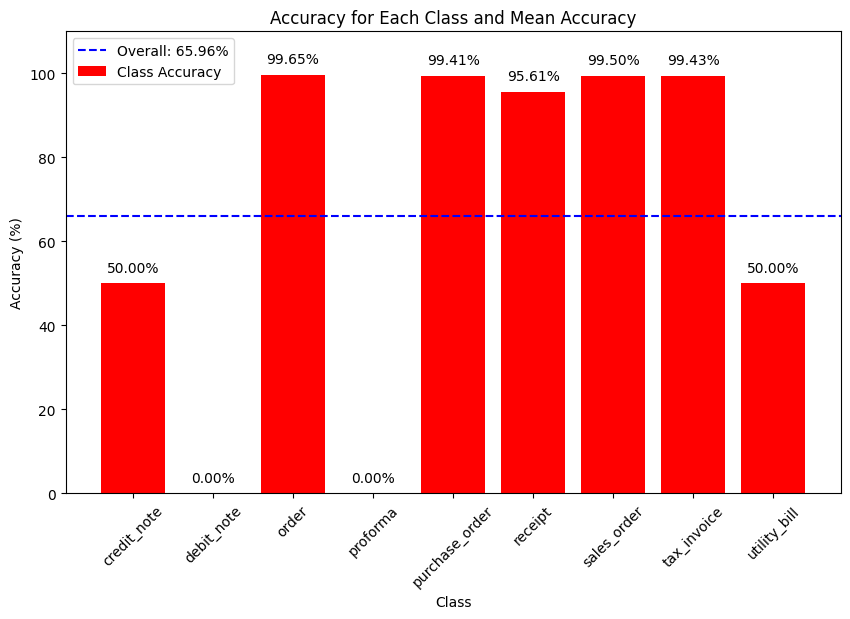

In [115]:
# Calculate the accuracy for each class
unique_classes = np.unique(y_test_names)
class_accuracies = []

for cls in unique_classes:
    correct_predictions = np.sum((y_test_names == cls) & (predicted_classes_names == cls))
    total_samples = np.sum(y_test_names == cls)
    
    # Check for potential division by zero errors
    if total_samples == 0:
        accuracy = 0.0
    else:
        accuracy = correct_predictions / total_samples
    
    class_accuracies.append(accuracy)

# Convert accuracies to percentages
class_percentages = [accuracy * 100 for accuracy in class_accuracies]

# Calculate the mean accuracy
mean_accuracy = np.mean(class_accuracies) * 100

# Create a bar plot with both class accuracies and mean accuracy
plt.figure(figsize=(10, 6))
bars = plt.bar(unique_classes, class_percentages, color='red', label='Class Accuracy')
plt.axhline(mean_accuracy, color='blue', linestyle='--', label=f'Overall: {(mean_accuracy/100):.2%}')

plt.xlabel('Class')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy for Each Class and Mean Accuracy')
plt.ylim(0, 110)  # Set the y-axis limits to 0-100 for percentages
plt.xticks(rotation=45)

# Add percentage labels above each bar
for bar, percentage in zip(bars, class_percentages):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 2, f'{percentage:.2f}%', ha='center', va='bottom')


# Add a legend
plt.legend()

plt.savefig('/home/sebastian/Documents/Hauptprojekt/Plots/ImageClassification/VGG16/Accuracy' + str(name_layer) + str(epochs) + 'epochs_' + str(mod_tax) + '_' + str(mod_order) + '.png')
plt.show()

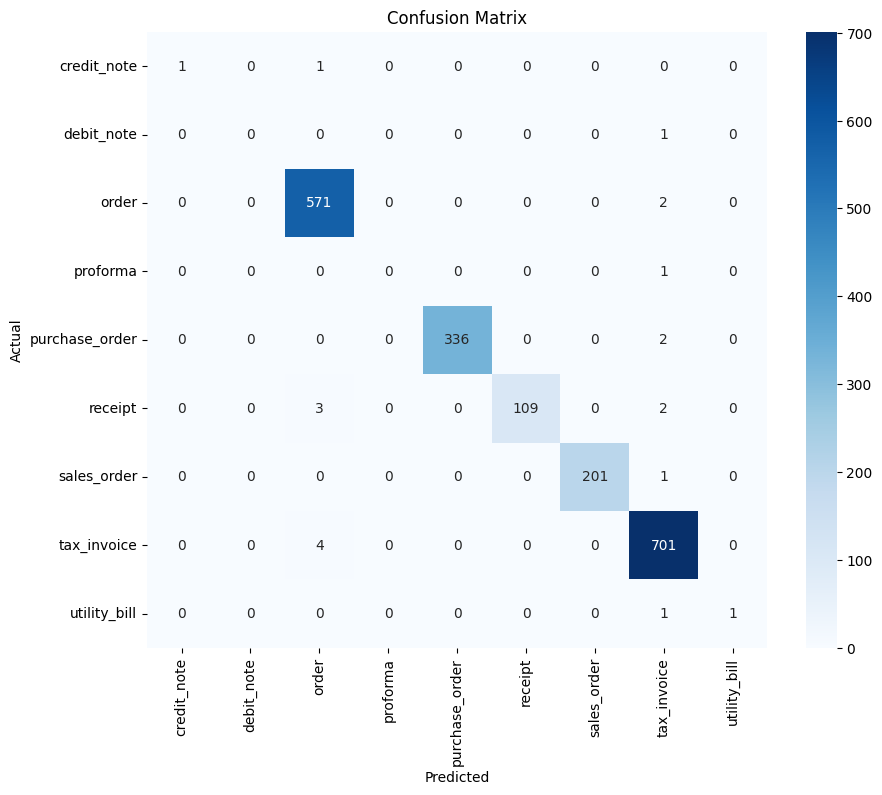

In [116]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# Create a confusion matrix
conf_matrix = confusion_matrix(y_test_names, predicted_classes_names, labels=np.unique(y_test_names))

# Display the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test_names), yticklabels=np.unique(y_test_names))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('/home/sebastian/Documents/Hauptprojekt/Plots/ImageClassification/VGG16/confusion_matrix' + str(name_layer) + str(epochs) + 'epochs_' + str(mod_tax) + '_' + str(mod_order) + '.png')
plt.show()

In [117]:
conf_matrix

array([[  1,   0,   1,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   1,   0],
       [  0,   0, 571,   0,   0,   0,   0,   2,   0],
       [  0,   0,   0,   0,   0,   0,   0,   1,   0],
       [  0,   0,   0,   0, 336,   0,   0,   2,   0],
       [  0,   0,   3,   0,   0, 109,   0,   2,   0],
       [  0,   0,   0,   0,   0,   0, 201,   1,   0],
       [  0,   0,   4,   0,   0,   0,   0, 701,   0],
       [  0,   0,   0,   0,   0,   0,   0,   1,   1]])

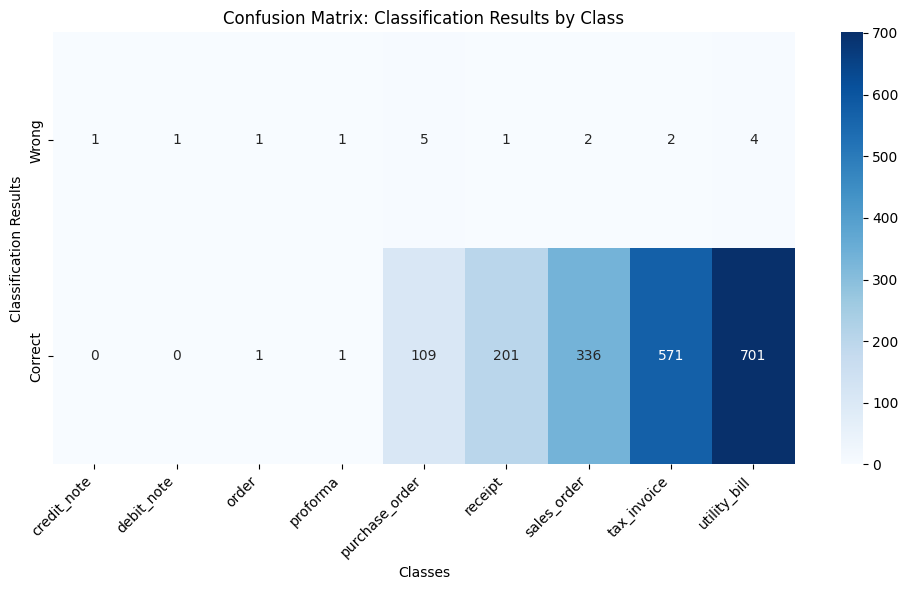

In [118]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define categories and data


wrong_counts = [
    false_pred.count("debit_note"),  # debit_note
    false_pred.count("proforma"),  # proforma
    false_pred.count("utility_bill"),  # utility_bill
    false_pred.count("credit_note"),  # credit_note
    false_pred.count("receipt"), # receipt
    false_pred.count("sales_order"),  # sales_order
    false_pred.count("purchase_order"),  # purchase_order
    false_pred.count("order"), # order
    false_pred.count("tax_invoice")  # tax_invoice
]
wrong_counts = np.array(wrong_counts)

total_counts = [
    false_pred.count("debit_note") + true_pred.count("debit_note"),   # debit_note
    false_pred.count("proforma") + true_pred.count("proforma"),   # proforma
    false_pred.count("utility_bill") + true_pred.count("utility_bill"),   # utility_bill
    false_pred.count("credit_note") + true_pred.count("credit_note"),   # credit_note
    false_pred.count("receipt") + true_pred.count("receipt"),  # receipt
    false_pred.count("sales_order") + true_pred.count("sales_order"), # sales_order
    false_pred.count("purchase_order") + true_pred.count("purchase_order"), # purchase_order
    false_pred.count("order") + true_pred.count("order"), # order
    false_pred.count("tax_invoice") + true_pred.count("tax_invoice")  # tax_invoice
]
total_counts = np.array(total_counts)

# Calculate percentage of wrong classifications
wrong_percentages = wrong_counts / total_counts * 100

# Create a confusion matrix
confusion_matrix = np.vstack((wrong_counts, total_counts - wrong_counts))

# Create a heatmap using Seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=categories, yticklabels=['Wrong', 'Correct'])
plt.xlabel('Classes')
plt.ylabel('Classification Results')
plt.title('Confusion Matrix: Classification Results by Class')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('/home/sebastian/Documents/Hauptprojekt/Plots/ImageClassification/VGG16/confusion_matrix2' + str(name_layer) + str(epochs) + 'epochs_' + str(mod_tax) + '_' + str(mod_order) + '.png')
plt.show()

In [119]:
confusion_matrix

array([[  1,   1,   1,   1,   5,   1,   2,   2,   4],
       [  0,   0,   1,   1, 109, 201, 336, 571, 701]])

In [120]:
with open("/home/sebastian/Documents/Hauptprojekt/Arrays/VGG16/F1_Scores.pkl", "rb") as file:
    F1_Scores = pickle.load(file)
with open("/home/sebastian/Documents/Hauptprojekt/Arrays/VGG16/Recall.pkl", "rb") as file:
    Recall = pickle.load(file)
with open("/home/sebastian/Documents/Hauptprojekt/Arrays/VGG16/ClassAccuracys.pkl", "rb") as file:
    ClassAccuracys = pickle.load(file)

In [121]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, classification_report

# Calculate accuracy
accuracy = accuracy_score(y_test_names, predicted_classes_names)

# Calculate F1 score for each class
f1_scores = f1_score(y_test_names, predicted_classes_names, average=None)

# Calculate recall for each class
recall_scores = recall_score(y_test_names, predicted_classes_names, average=None)

# Print accuracy
print(f"Accuracy: {accuracy:.2f}")

# Print F1 score and recall for each class
for class_idx, (f1, recall) in enumerate(zip(f1_scores, recall_scores)):
    print(f"Class {class_idx}:")
    print(f"F1 Score: {f1:.3f}")
    print(f"Recall: {recall:.3f}")
    

Accuracy: 0.99
Class 0:
F1 Score: 0.667
Recall: 0.500
Class 1:
F1 Score: 0.000
Recall: 0.000
Class 2:
F1 Score: 0.991
Recall: 0.997
Class 3:
F1 Score: 0.000
Recall: 0.000
Class 4:
F1 Score: 0.997
Recall: 0.994
Class 5:
F1 Score: 0.978
Recall: 0.956
Class 6:
F1 Score: 0.998
Recall: 0.995
Class 7:
F1 Score: 0.990
Recall: 0.994
Class 8:
F1 Score: 0.667
Recall: 0.500


In [122]:
F1_Scores['VGG16_F1' + str(name_layer) + str(epochs) + 'epochs_' + str(mod_tax) + '_' + str(mod_order)] = f1_scores
Recall['VGG16_Recall' + str(name_layer) + str(epochs) + 'epochs_' + str(mod_tax) + '_' + str(mod_order)] = recall_scores
ClassAccuracys['VGG16_ClassAcc' + str(name_layer) + str(epochs) + 'epochs_' + str(mod_tax) + '_' + str(mod_order)] = class_accuracies

In [123]:
with open("/home/sebastian/Documents/Hauptprojekt/Arrays/VGG16/F1_Scores.pkl", 'wb') as file:
    pickle.dump(F1_Scores, file)


with open("/home/sebastian/Documents/Hauptprojekt/Arrays/VGG16/Recall.pkl", 'wb') as file:
    pickle.dump(Recall, file)

with open("/home/sebastian/Documents/Hauptprojekt/Arrays/VGG16/ClassAccuracys.pkl", 'wb') as file:
    pickle.dump(ClassAccuracys, file)

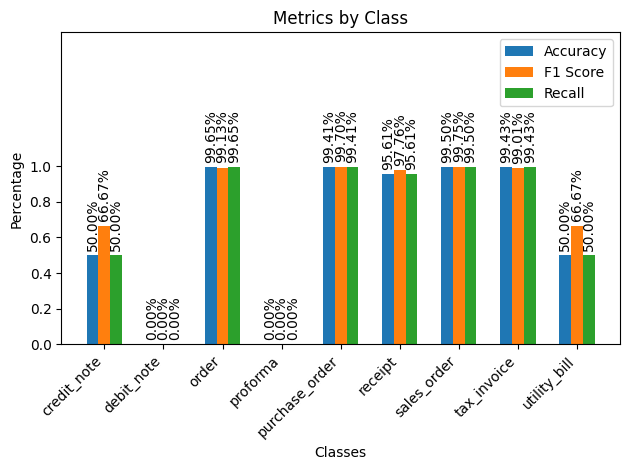

In [124]:
import numpy as np
import matplotlib.pyplot as plt



# values for accuracy, F1 score, and recall for each class
accuracy_values = class_accuracies
f1_score_values = f1_scores
recall_values = recall_scores

# Set the width of the bars
bar_width = 0.2

# Calculate the x-axis positions for each class
x = np.arange(len(categories))

# Create subplots for accuracy, F1 score, and recall
fig, ax = plt.subplots()

# Create bars for each metric
bar_accuracy = ax.bar(x - bar_width, accuracy_values, width=bar_width, label='Accuracy')
bar_f1_score = ax.bar(x, f1_score_values, width=bar_width, label='F1 Score')
bar_recall = ax.bar(x + bar_width, recall_values, width=bar_width, label='Recall')

y_ticks = np.arange(0, 1.1, 0.2)
ax.set_yticks(y_ticks)
ax.set_yticklabels([f"{tick:.1f}" for tick in y_ticks])

# Set the labels for x-axis and y-axis
ax.set_xlabel('Classes')
ax.set_ylabel('Percentage')
ax.set_title('Metrics by Class')
ax.set_xticks(x)
ax.set_xticklabels(categories, rotation=45, ha="right")
ax.legend()

# Display percentages on top of the bars turned by 90 degrees
for bars in [bar_accuracy, bar_f1_score, bar_recall]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2%}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
                    textcoords='offset points', ha='center', va='bottom', rotation=90)
# Set the y-axis limit to 110
ax.set_ylim(0, 1.75)
# Show the plot
plt.tight_layout()
plt.savefig('/home/sebastian/Documents/Hauptprojekt/Plots/ImageClassification/VGG16/metrics'+ str(name_layer) + str(epochs) + 'epochs_' + str(mod_tax) + '_' + str(mod_order) + '.png')
plt.show()


In [125]:
F1_Scores

{'VGG16_F1_added_layer_30epochs_10_5': array([0.66666667, 0.        , 0.99131944, 0.        , 0.99703264,
        0.97757848, 0.99751861, 0.99011299, 0.66666667]),
 'VGG16_F1_added_layer_50epochs_10_5': array([0.66666667, 0.        , 0.98956522, 0.66666667, 0.99556869,
        0.97297297, 0.99502488, 0.98939929, 0.66666667]),
 'VGG16_F1_all_layer_30epochs_10_5': array([0.66666667, 0.        , 0.991274  , 0.        , 0.99705015,
        0.97757848, 0.99751861, 0.99082569, 0.66666667]),
 'VGG16_F1_added_layer_100epochs_10_5': array([0.66666667, 0.        , 0.9912892 , 0.        , 0.99851852,
        0.97757848, 0.9950495 , 0.98941426, 0.66666667]),
 'VGG16_F1_all_layer_50epochs_10_5': array([0.66666667, 1.        , 0.99047619, 1.        , 0.99851852,
        0.97321429, 0.99751861, 0.99289773, 1.        ]),
 'VGG16_F1_all_layer_100epochs_10_5': array([0.66666667, 0.        , 0.99474606, 1.        , 0.99556869,
        0.97321429, 0.99751861, 0.99085151, 0.66666667])}